In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import seaborn as sns

In [2]:
stat_kernel_CARMA = pd.read_csv('stat_kernel_CARMA.csv', sep = ',', decimal = '.', low_memory = False)

In [3]:
stat_kernel_proof = pd.read_csv('stat_kernel_proof.csv', sep = ',', decimal = '.', low_memory = False)

In [4]:
stat_kernel = pd.DataFrame()
stat_kernel = pd.concat([stat_kernel_CARMA, stat_kernel_proof])

In [5]:
stat_kernel = stat_kernel.reset_index(drop = True)

In [6]:
for f in range(1, 5):
    globals()['stat_kernel_f{}'.format(f)] = stat_kernel[stat_kernel.veh_position == f]

In [7]:
for f in range(1, 5):
    globals()['stat_kernel_f{}'.format(f)] = globals()['stat_kernel_f{}'.format(f)].reset_index(drop = True)

In [8]:
#création de H, pour chaque position, la valeur de h est différente
H = [0.8, 0.8, 2, 2]
#création des plages de données à tracer pour chaque position en fonction des valeurs de temps de réponse obtenu
#for f in range(1, 5):
    #globals()['X{}'.format(f)] = np.linspace(int(min(globals()['stat_kernel_f{}'.format(f)].reaction_time)) - 2, int(max(globals()['stat_kernel_f{}'.format(f)].reaction_time)) + 2, 1000)

In [9]:
X1 = np.linspace(-2, 9, 1000)
X2 = np.linspace(0, 14, 1000)
X3 = np.linspace(0, 18, 1000)
X4 = np.linspace(0, 22, 1000)

In [10]:
def densite(valeurs, h, Xf):
    #cette fonction calcule pour chaque élément de Xi, 
    #la somme des distributions normales associées à chacune des valeurs de TR
    Y = np.zeros(len(Xf))
    n = len(valeurs)
    for i in range(len(Xf)):
        Y[i] = 1 / (n * h * np.sqrt(2 * np.pi)) * sum([np.exp(-(Xf[i] - Xi) ** 2\
        / (2 * h ** 2)) for Xi in valeurs])
    return Y

In [11]:
len(globals()['stat_kernel_f{}'.format(4)][globals()['stat_kernel_f{}'.format(4)].veh_mode == 1].reaction_time)

34

1
2
3
4


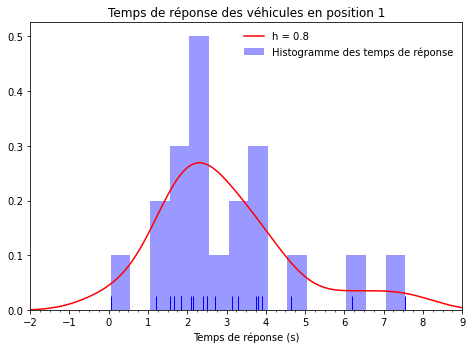

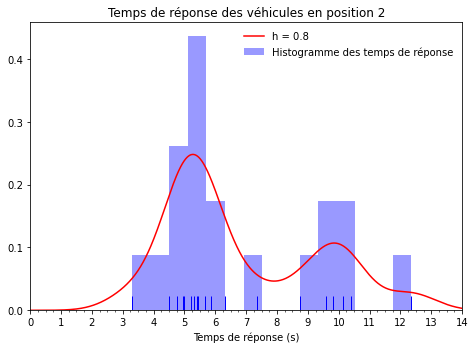

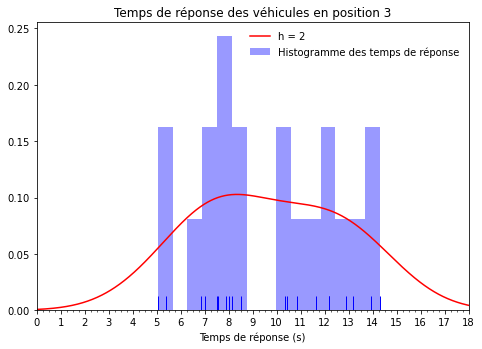

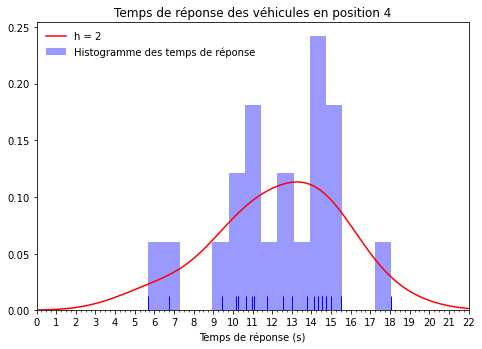

In [12]:
for f in range(1, 5):
    print(f)
    Y = densite(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode == 0].reaction_time,\
                H[f - 1], globals()['X{}'.format(f)])
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    sns.distplot(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode == 0].reaction_time, 15, color='b',\
                 rug=True, kde_kws={'color': 'k', 'lw': 0}, label='Histogramme des temps de réponse')
    ax.plot(globals()['X{}'.format(f)], Y, color='r', label="h = " + str(H[f - 1]))
    #ax.plot((1.26, 1.26), (0, 0.4))
    if f == 1:
        ax.set_xlim(-2, 9)
    elif f == 2:
        ax.set_xlim(0, 14)
    elif f == 3:
        ax.set_xlim(0, 18)
    elif f == 4:
        ax.set_xlim(0, 22)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.25))
    ax.set_xlabel("Temps de réponse (s)")
    ax.set_title("Temps de réponse des véhicules en position {}".format(f))
    ax.legend(loc='best', frameon=False)

plt.show()

In [13]:
#trouver le minimum de la fonction de répartition
def min_repartition(stat_kernel, h, Xf):
    Y = densite(stat_kernel, h, Xf)
    #on a besoin du maximum global car le mode CACC est majoritaire
    Y_Max = max(Y)
    x_Max = list(Y).index(Y_Max)
    #on veut trouver le minimum de la fonction de répartition
    #on part du maximum global
    x = x_Max
    #on veut parcourir la liste Xf et travailler avec les variations
    while Y[x + 1] - Y[x] < 0:
        x += 1
    x_Min = x
    Y_Min = Y[x]
    return Xf[x_Min]

In [14]:
for f in range(1, 5):
    print(min_repartition(globals()['stat_kernel_f{}'.format(f)].reaction_time,\
                                           H[f - 1], globals()['X{}'.format(f)]))

6.236236236236236
2.2002002002002


IndexError: index 1000 is out of bounds for axis 0 with size 1000

In [ ]:
#définition du facteur de comparaison utilisé pour avoir les proportions de véhicules en CACC parmi l'échantillon CACC
#on prend ce facteur pour tous les TR entre le leader et le premier suiveur car seuls deux évènements sont possibles :
#le F1 est en CACC ou le F1 fonctionne comme un ACC
facteur_comp = min_repartition(globals()['stat_kernel_f{}'.format(1)].reaction_time,\
                                           H[0], globals()['X{}'.format(1)])

In [ ]:
facteur_comp

In [ ]:
#trouver la répartition des valeurs dans les deux intervalles à partir du minimum local
def repartition(stat_kernel, h, Xf, facteur):
    val_CACC = []
    val_ACC = []
    #la ligne ci-dessous est utile si on raisonne différemment pour chaque suiveur
    #ce qui n'est aps le cas ici
    #Y_Min = min_repartition(stat_kernel, h, Xf)
    for val in stat_kernel:
        #si la valeur est supérieure à la valeur du minimum de la fonction, on la considère comme ACC
        if val > facteur:
            val_ACC.append(val)
        #sinon on la considère comme CACC
        elif val < facteur:
            val_CACC.append(val)
    return val_CACC, val_ACC

In [ ]:
#trouver la proportion de chacun des modes par position
def mode(stat_kernel, h, Xf, facteur):
    val_CACC, val_ACC = repartition(stat_kernel, h, Xf, facteur)
    return (len(val_CACC)/len(stat_kernel)*100, len(val_ACC)/len(stat_kernel)*100)

In [ ]:
for f in range(1, 5):
    print(f)
    globals()['mode_f{}'.format(f)] = mode(globals()['stat_kernel_f{}'.format(f)][globals()['stat_kernel_f{}'.format(f)].veh_mode == 1].reaction_time,\
                                           H[f - 1], globals()['X{}'.format(f)], facteur_comp)
    print("CACC : ")
    print(globals()['mode_f{}'.format(f)][0])
    print("ambigu : ")
    print(globals()['mode_f{}'.format(f)][1])